<a href="https://colab.research.google.com/github/saqlineniam/Strawberry/blob/main/SRV_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, make_scorer
import statsmodels.api as sm
import os
from sklearn.inspection import permutation_importance
import joblib
from collections import defaultdict
from sklearn.model_selection import RepeatedKFold, cross_validate

In [ ]:
df = pd.read_excel(r"Df.xlsx")

In [ ]:
df.head()

,Unnamed: 0,Treatment,Days,Alginate,Guargum,Pectin,WeightLoss,Firmness,TSS,pH,ΔE,L,a,b,TPC,DPPH
0,NaN,0,2,0.0,0.0,0.0,14.69,468.69,4.6,4.11,9.398904,14.51,4.14,19.10,816.88,82.32
1,NaN,1,2,3.0,0.0,0.0,8.54,457.32,5.9,4.07,7.734145,14.79,7.66,19.24,811.88,79.05
2,NaN,2,2,0.0,3.0,0.0,9.03,509.90,5.8,4.08,7.604591,20.34,14.48,21.83,436.88,90.84
3,NaN,3,2,0.0,0.0,3.0,8.59,588.24,6.1,4.14,5.112592,17.86,11.75,18.80,358.13,91.65
4,NaN,4,2,1.5,1.5,0.0,7.69,682.79,6.4,4.05,2.631045,19.25,10.39,15.69,413.13,93.62


In [ ]:
x = df.iloc[:,2:6]
y = df.iloc[:,6:11]

In [ ]:
n_targets = ['WeightLoss', 'Firmness', 'TSS', 'pH', 'ΔE']

In [ ]:
x.head()

,Days,Alginate,Guargum,Pectin
0,2,0.0,0.0,0.0
1,2,3.0,0.0,0.0
2,2,0.0,3.0,0.0
3,2,0.0,0.0,3.0
4,2,1.5,1.5,0.0


In [ ]:
y

,WeightLoss,Firmness,TSS,pH,ΔE
0,14.69,468.69,4.6,4.11,9.398904
1,8.54,457.32,5.9,4.07,7.734145
2,9.03,509.90,5.8,4.08,7.604591
3,8.59,588.24,6.1,4.14,5.112592
4,7.69,682.79,6.4,4.05,2.631045
...,...,...,...,...,...
94,28.93,131.20,1.0,4.56,22.055943
95,12.51,394.67,3.1,4.26,9.838852
96,24.86,234.59,1.7,4.37,11.152426
97,26.70,308.56,1.6,4.27,14.067679


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=21)


In [ ]:
y_train_arr  = Y_train.to_numpy()

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=2, random_state=21)

In [ ]:
# === Pipeline & Param Grid ===
pipe_svr = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", MultiOutputRegressor(SVR()))
])
param_grid_svr = {
    "reg__estimator__C":       [1, 10, 50, 100, 200, 500],
    "reg__estimator__epsilon": [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.05, 0.1, 0.2, 0.5, 1],
    "reg__estimator__kernel":  ["rbf","linear"],
    "reg__estimator__gamma": ["scale", "auto", 0.1, 0.01, 0.001],
}


In [ ]:
param_grid_svr = {
    # Regularization: lower C → smoother (higher bias), higher C → tighter fit (higher variance)
    "reg__estimator__C":       [0.1, 1, 10, 100, 500],

    # Epsilon-tube width: smaller → force tighter fit, larger → allow more slack
    "reg__estimator__epsilon": [0.001, 0.01, 0.1, 0.5],

    # Kernels: linear for simplicity, RBF/poly for nonlinearity
    "reg__estimator__kernel":  ["linear", "rbf", "poly"],

    # Gamma: kernel coefficient for RBF/poly
    "reg__estimator__gamma":   ["scale", "auto", 0.01, 0.1],

    # Degree only matters if kernel='poly'
    "reg__estimator__degree":  [2, 3]
}

In [ ]:
# === 5. GridSearchCV on the training set ===
grid = GridSearchCV(
    pipe_svr,
    param_grid=param_grid_svr,
    scoring="neg_root_mean_squared_error",
    cv=cv,              # 5-fold CV on training data
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, Y_train)

print("Best hyperparameters:", grid.best_params_)
print("Best CV neg-RMSE:", grid.best_score_)

Fitting 20 folds for each of 700 candidates, totalling 14000 fits
Best hyperparameters: {'reg__estimator__C': 1000, 'reg__estimator__epsilon': 0.01, 'reg__estimator__gamma': 'auto', 'reg__estimator__kernel': 'rbf'}
Best CV neg-RMSE: -5.647352635802275


In [ ]:
# === 6. Predict on train & test ===
best_model = grid.best_estimator_

Y_train_pred = best_model.predict(X_train)
Y_test_pred  = best_model.predict(X_test)

In [ ]:
joblib.dump(best_model, "best_svr_pipeline.pkl")

['best_svr_pipeline.pkl']

In [ ]:
# Convert predictions to DataFrames with the same columns as Y_train
Y_train_pred_df = pd.DataFrame(Y_train_pred, columns=Y_train.columns, index=Y_train.index)
Y_test_pred_df  = pd.DataFrame(Y_test_pred,  columns=Y_test.columns,  index=Y_test.index)

In [ ]:
metrics = []
for col in Y_train.columns:
    true_tr = Y_train[col]
    pred_tr = Y_train_pred_df[col]
    true_te = Y_test[col]
    pred_te = Y_test_pred_df[col]

    # Compute RMSE via sqrt of MSE
    train_rmse = np.sqrt(mean_squared_error(true_tr, pred_tr))
    test_rmse  = np.sqrt(mean_squared_error(true_te,  pred_te))

    train_mae = mean_absolute_error(true_tr, pred_tr)
    test_mae  = mean_absolute_error(true_te,  pred_te)

    train_r2  = r2_score(true_tr, pred_tr)
    test_r2   = r2_score(true_te,  pred_te)

    metrics.append({
        "target":     col,
        "train_RMSE": train_rmse,
        "test_RMSE":  test_rmse,
        "train_MAE":  train_mae,
        "test_MAE":   test_mae,
        "train_R2":   train_r2,
        "test_R2":    test_r2
    })

# Build and show DataFrame
metrics_df = pd.DataFrame(metrics).set_index("target")
print(metrics_df)
metrics_df.to_excel("model_performance_metrics.xlsx", index=True)

            train_RMSE  test_RMSE  train_MAE  test_MAE  train_R2   test_R2
target                                                                    
WeightLoss    0.456250   0.375301   0.209770  0.308176  0.995813  0.997401
Firmness     12.627438  15.203707   5.017652  9.712596  0.992710  0.989575
TSS           0.292176   0.468282   0.132306  0.256119  0.957923  0.892203
pH            0.036204   0.069326   0.025117  0.053751  0.947394  0.853222
ΔE            1.096042   1.473110   0.551790  1.122260  0.942123  0.880702


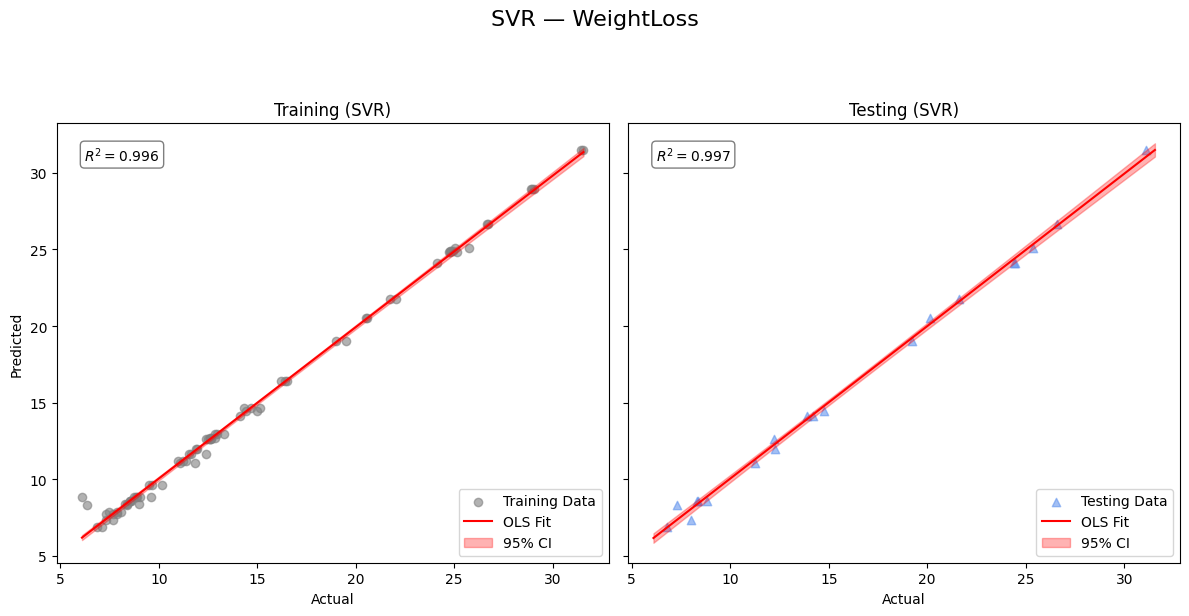

Saved SVR plot to svr_comparison_plots/svr_actual_vs_pred_WeightLoss.png


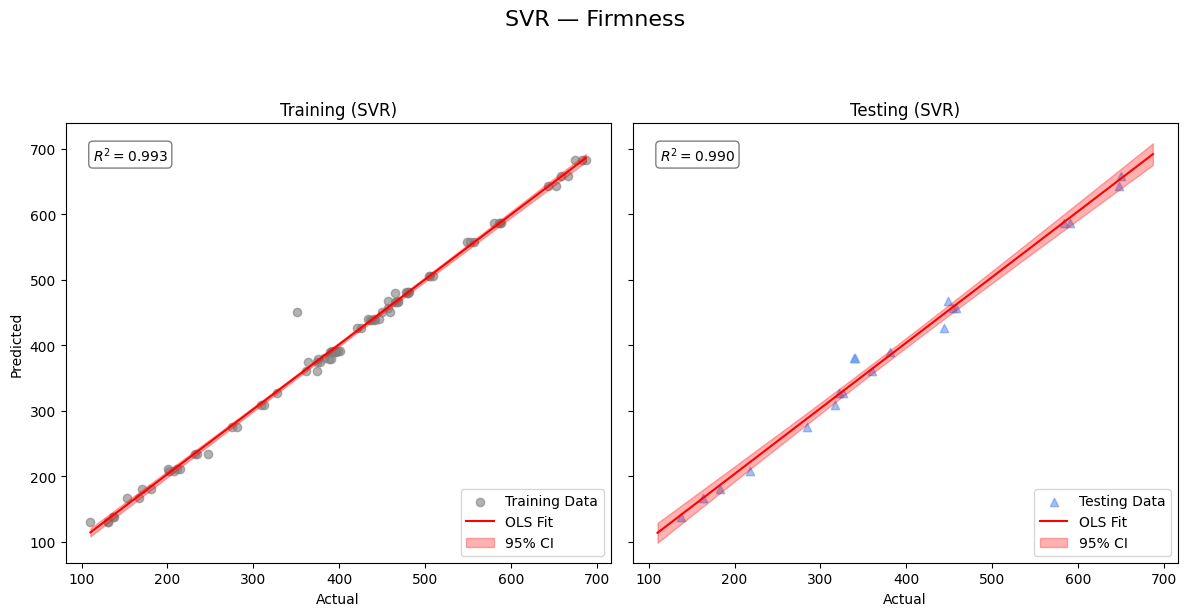

Saved SVR plot to svr_comparison_plots/svr_actual_vs_pred_Firmness.png


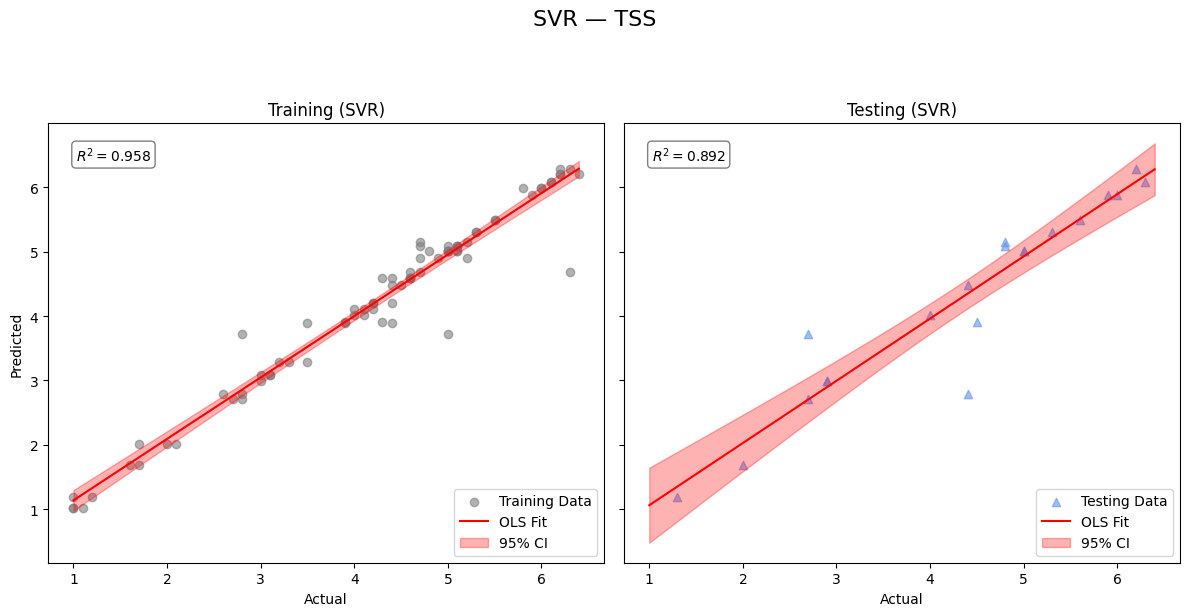

Saved SVR plot to svr_comparison_plots/svr_actual_vs_pred_TSS.png


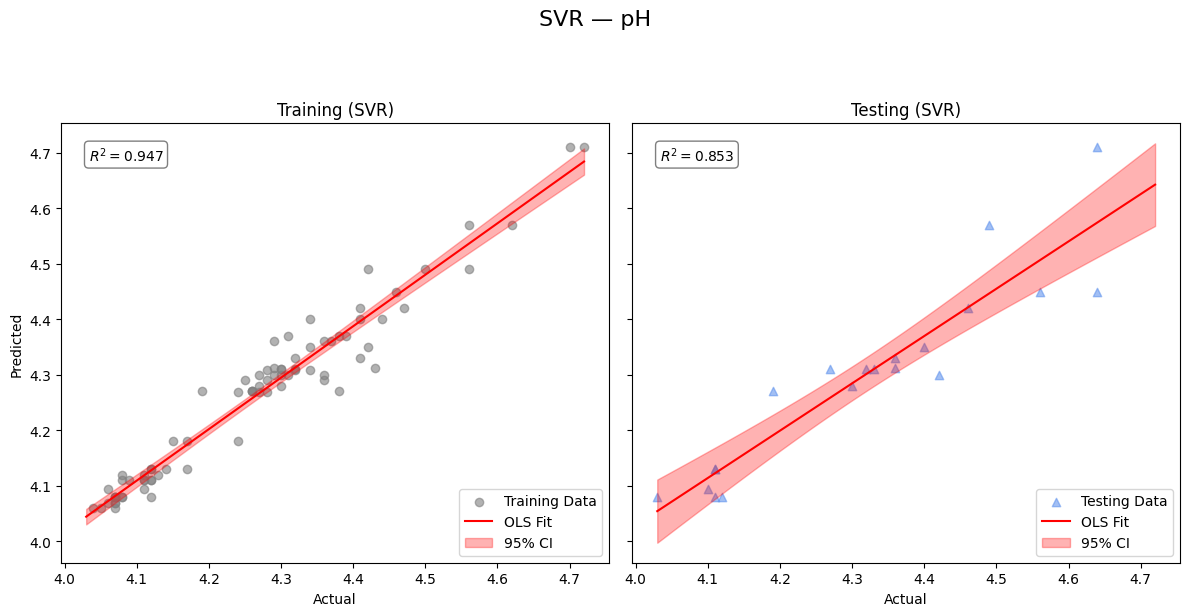

Saved SVR plot to svr_comparison_plots/svr_actual_vs_pred_pH.png


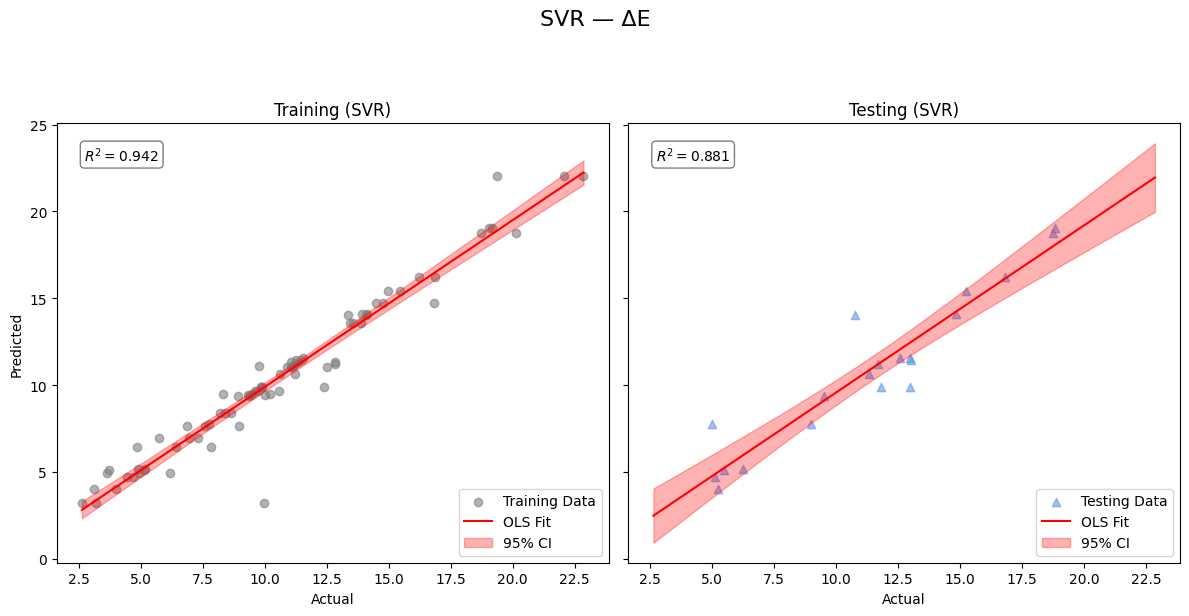

Saved SVR plot to svr_comparison_plots/svr_actual_vs_pred_ΔE.png


In [ ]:
# 2) Create output folder
os.makedirs("svr_comparison_plots", exist_ok=True)

# 3) Loop over each target
for target in Y_train.columns:
    y_tr = Y_train[target].values
    yp_tr = Y_train_pred_df[target].values
    y_te = Y_test[target].values
    yp_te = Y_test_pred_df[target].values

    # Compute R²
    r2_tr = r2_score(y_tr, yp_tr)
    r2_te = r2_score(y_te, yp_te)

    # Range for plotting the regression line & CI
    mn, mx = min(y_tr.min(), y_te.min()), max(y_tr.max(), y_te.max())
    xg = np.linspace(mn, mx, 100)

    # Fit OLS on train
    ols_tr = sm.OLS(yp_tr, sm.add_constant(y_tr)).fit()
    ci_tr = ols_tr.get_prediction(sm.add_constant(xg)).summary_frame(alpha=0.05)
    # Fit OLS on test
    ols_te = sm.OLS(yp_te, sm.add_constant(y_te)).fit()
    ci_te = ols_te.get_prediction(sm.add_constant(xg)).summary_frame(alpha=0.05)

    # 4) Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

    # TRAINING panel
    ax1.scatter(y_tr, yp_tr, color='gray', alpha=0.6, label="Training Data")
    ax1.plot(xg, ci_tr['mean'], color='red', label="OLS Fit")
    ax1.fill_between(xg, ci_tr['mean_ci_lower'], ci_tr['mean_ci_upper'],
                     color='red', alpha=0.3, label="95% CI")
    ax1.text(0.05, 0.95, f'$R^2={r2_tr:.3f}$', transform=ax1.transAxes,
             va='top', ha='left', bbox=dict(boxstyle='round,pad=0.3',
             fc='white', ec='black', alpha=0.5))
    ax1.set_title("Training (SVR)")
    ax1.set_xlabel("Actual")
    ax1.set_ylabel("Predicted")
    ax1.legend(loc='lower right')

    # TESTING panel
    ax2.scatter(y_te, yp_te, color='cornflowerblue', marker='^', alpha=0.6, label="Testing Data")
    ax2.plot(xg, ci_te['mean'], color='red', label="OLS Fit")
    ax2.fill_between(xg, ci_te['mean_ci_lower'], ci_te['mean_ci_upper'],
                     color='red', alpha=0.3, label="95% CI")
    ax2.text(0.05, 0.95, f'$R^2={r2_te:.3f}$', transform=ax2.transAxes,
             va='top', ha='left', bbox=dict(boxstyle='round,pad=0.3',
             fc='white', ec='black', alpha=0.5))
    ax2.set_title("Testing (SVR)")
    ax2.set_xlabel("Actual")
    ax2.legend(loc='lower right')

    # Super title & layout
    fig.suptitle(f"SVR — {target}", y=1.02, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Save to file
    fname = f"svr_actual_vs_pred_{target.replace(' ', '_')}.png"
    fig.savefig(os.path.join("svr_comparison_plots", fname), dpi=300, bbox_inches="tight")
    plt.close(fig)
    plt.show()
    print(f"Saved SVR plot to svr_comparison_plots/{fname}")

In [ ]:
def summarize(name, Y_true, Y_pred):
    # compute RMSE explicitly
    rmse = np.sqrt(mean_squared_error(Y_true, Y_pred))
    mae  = mean_absolute_error(Y_true, Y_pred)
    r2   = r2_score(Y_true, Y_pred)
    print(f"{name} → RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

# after GridSearchCV and best_model.predict:
Y_train_pred = best_model.predict(X_train)
Y_test_pred  = best_model.predict(X_test)

summarize("Train", Y_train, Y_train_pred)
summarize("Test",  Y_test,  Y_test_pred)

Train → RMSE: 10.452, MAE: 1.906, R²: 0.953
Test → RMSE: 21.034, MAE: 5.732, R²: 0.912


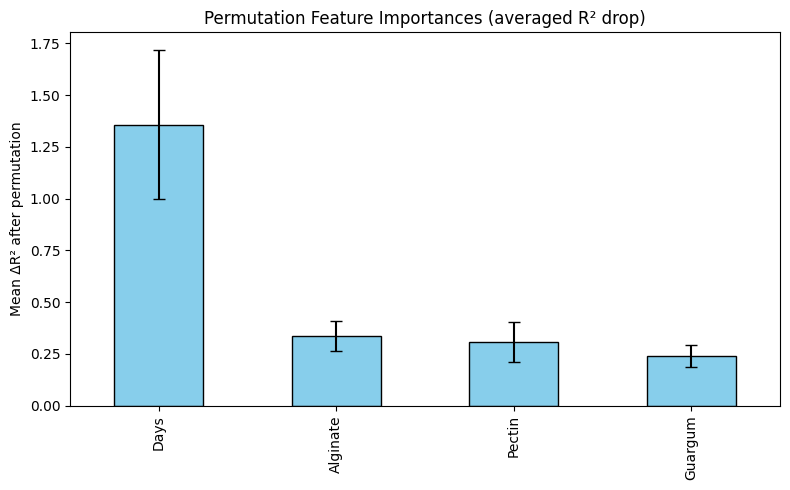

In [ ]:
# 1) Define an averaged‐R² scorer across all outputs
def avg_r2(y_true, y_pred):
    # multioutput='raw_values' returns one R2 per target
    return np.mean(r2_score(y_true, y_pred, multioutput='raw_values'))

r2_scorer = make_scorer(avg_r2)

# 2) Compute permutation importances on the test set
# best_model is your trained Pipeline (with scaler + MultiOutputRegressor)
# X_test, Y_test are your hold‐out sets (arrays or DataFrames)
res = permutation_importance(
    best_model, X_test, Y_test,
    scoring=r2_scorer,
    n_repeats=30,      # more repeats → smoother estimates
    random_state=0,
    n_jobs=-1
)

# 3) Aggregate into a pandas Series
# If X_test is a DataFrame, use its columns; otherwise supply a list of names
feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"X{i}" for i in range(X_test.shape[1])]
importances = pd.Series(res.importances_mean, index=feature_names)
stds        = pd.Series(res.importances_std,  index=feature_names)

# 4) Sort descending
importances = importances.sort_values(ascending=False)
stds        = stds.loc[importances.index]

# 5) Plot
plt.figure(figsize=(8,5))
importances.plot.bar(yerr=stds, capsize=4, color='skyblue', edgecolor='k')
plt.ylabel("Mean ΔR² after permutation")
plt.title("Permutation Feature Importances (averaged R² drop)")
plt.tight_layout()
plt.savefig("permutation_feature_importance.png", dpi=300)
plt.show()

In [ ]:
X_all= x
Y_all = y

In [ ]:
outer_kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=21)
inner_kfold = RepeatedKFold(n_splits=10, n_repeats=2, random_state=21)

In [ ]:
svr_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("multi_svr", MultiOutputRegressor(SVR()))
])
svr_param_grid = {
    "multi_svr__estimator__C":       [1, 10, 50, 100, 200, 500, 1000],
    "multi_svr__estimator__epsilon": [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.05, 0.1, 0.2, 0.5, 1],
    "multi_svr__estimator__kernel":  ["rbf", "linear"],
    "multi_svr__estimator__gamma":   ["scale", "auto", 0.1, 0.01, 0.001]
}

In [ ]:
grid = GridSearchCV(pipe_svr, param_grid_svr,
                    scoring="neg_root_mean_squared_error",
                    cv=inner_cv, n_jobs=-1)

cvres = cross_validate(grid,
                       x, y,
                       cv=outer_cv,
                       scoring=["neg_root_mean_squared_error"],
                       return_train_score=False,
                       n_jobs=-1)

mean_rmse = -cvres["test_neg_root_mean_squared_error"].mean()
std_rmse  =  cvres["test_neg_root_mean_squared_error"].std()
print(f"Nested‐CV overall RMSE = {mean_rmse:.3f} ± {std_rmse:.3f}")

# 2) Get out‐of‐fold predictions for each target
y_oof = cross_val_predict(grid,
                          x, y,
                          cv=outer_cv,
                          n_jobs=-1)   # shape = (n_samples, n_targets)

# Wrap into a DataFrame aligned with your original y
y_oof_df = pd.DataFrame(y_oof, columns=y.columns, index=y.index)

# 3) Compute per‐target metrics
records = []
for tgt in y.columns:
    y_true = y[tgt]
    y_pred = y_oof_df[tgt]
    records.append({
        "target":     tgt,
        "train_RMSE": np.nan,  # nested‐CV doesn’t give a single train‐fold prediction
        "test_RMSE":  np.sqrt(mean_squared_error(y_true, y_pred)),
        "train_MAE":  np.nan,
        "test_MAE":   mean_absolute_error(y_true, y_pred),
        "train_R2":   np.nan,
        "test_R2":    r2_score(y_true, y_pred)
    })

per_target_metrics = pd.DataFrame(records).set_index("target")
print("\nPer‐target OOF metrics:\n", per_target_metrics)

# 4) If you *must* get 'train' numbers, you can also collect them via another cross_val_predict
#    on the training‐portion of each outer fold, but typically only 'test' (OOF) is reported.

# 5) Save final model (refit on full data)
final = GridSearchCV(pipe_svr, param_grid_svr,
                     scoring="neg_root_mean_squared_error",
                     cv=inner_cv, n_jobs=-1)
final.fit(x, y)
best_model = final.best_estimator_
joblib.dump(best_model, "svr_multioutput_nested.pkl")